# GSM8K Ablation Analysis

Compare Δ (log P(correct) - max log P(wrong)) across:
- Baseline
- Hint
- Hint + Ablation
- Baseline + Ablation (control)

Tests both Q ablation and o_proj ablation methods.

In [1]:
import os
import json
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

os.environ["HF_HOME"] = "/workspace/.cache/huggingface"

SEED = 42
torch.manual_seed(SEED)

In [16]:
# Ablation config
ABLATE_LAYERS = list(range(28))
ABLATE_HEAD = 5

# Load logprobs data to get target problems
LOGPROBS_FILE = "gsm8k_hint_experiment_n200_tok512_logprobs.jsonl"


## Setup

Load model and configuration.

In [17]:
# Load model
MODEL = "Qwen/Qwen3-0.6B"

tok = AutoTokenizer.from_pretrained(MODEL)
tok.padding_side = "left"
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager",
)
model.eval()

NUM_HEADS = model.config.num_attention_heads
HEAD_DIM = model.config.hidden_size // NUM_HEADS
print(f"Model: {MODEL}")
print(f"Heads: {NUM_HEADS}, Head dim: {HEAD_DIM}")

Model: Qwen/Qwen3-0.6B
Heads: 16, Head dim: 64


In [18]:
# Load rollouts and identify target problems (same logic as patching notebook)
rollouts = []
with open(LOGPROBS_FILE, "r") as f:
    for line in f:
        rollouts.append(json.loads(line))

# Group by problem
by_problem = {}
for r in rollouts:
    idx = r["problem_idx"]
    if idx not in by_problem:
        by_problem[idx] = {}
    by_problem[idx][r["mode"]] = r

# Find target problems: baseline prefers wrong, hint prefers correct
target_problems = []
for problem_idx, modes in by_problem.items():
    if "baseline" not in modes or "hint_correct_silent" not in modes:
        continue
    
    baseline = modes["baseline"]
    hint = modes["hint_correct_silent"]
    correct_answer = baseline["correct_answer"]
    
    # Filter: same digit count for answer ± 2
    answer_digits = len(str(correct_answer))
    offsets = [-2, -1, 1, 2]
    all_same_digits = all(
        len(str(correct_answer + offset)) == answer_digits and (correct_answer + offset) > 0
        for offset in offsets
    )
    if not all_same_digits:
        continue
    
    # Get before_think checkpoint
    baseline_cp = next((cp for cp in baseline["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    hint_cp = next((cp for cp in hint["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    
    if baseline_cp is None or hint_cp is None:
        continue
    
    baseline_probs = baseline_cp["cand_softmax"]
    hint_probs = hint_cp["cand_softmax"]
    
    baseline_nonhint = {k: v for k, v in baseline_probs.items() if k != "hint"}
    baseline_best = max(baseline_nonhint.items(), key=lambda x: x[1])[0]
    hint_best = max(hint_probs.items(), key=lambda x: x[1])[0]
    
    if baseline_best != "correct" and hint_best == "correct":
        target_problems.append({
            "problem_idx": problem_idx,
            "question": baseline["question"],
            "correct_answer": correct_answer,
            "hint_value": hint["hint_value"],
            "baseline_prompt": baseline["prompt"],
            "hint_prompt": hint["prompt"],
        })

print(f"Found {len(target_problems)} target problems")

Found 70 target problems


In [19]:
# Compute answer logprobs function (from patching notebook)
@torch.inference_mode()
def compute_answer_logprobs_from_tokens(context_token_ids, correct_answer, hint_value=None):
    answer_prefix_ids = tok.encode("\nAnswer: ", add_special_tokens=False)
    prefix_ids = context_token_ids + answer_prefix_ids
    prefix_len = len(prefix_ids)

    candidates = {"correct": correct_answer}
    for offset in [-2, -1, 1, 2]:
        val = correct_answer + offset
        if val > 0:
            candidates[f"wrong_{offset:+d}"] = val
    if hint_value is not None and hint_value != correct_answer:
        candidates["hint"] = hint_value

    cand_names = list(candidates.keys())
    cand_token_lists = [tok.encode(str(candidates[name]), add_special_tokens=False) for name in cand_names]

    seqs = [prefix_ids + cand_ids for cand_ids in cand_token_lists]
    max_len = max(len(s) for s in seqs)

    pad_id = tok.pad_token_id if tok.pad_token_id is not None else tok.eos_token_id
    input_ids = torch.full((len(seqs), max_len), pad_id, device=model.device, dtype=torch.long)
    attention_mask = torch.zeros((len(seqs), max_len), device=model.device, dtype=torch.long)

    for i, s in enumerate(seqs):
        L = len(s)
        input_ids[i, :L] = torch.tensor(s, device=model.device)
        attention_mask[i, :L] = 1

    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

    results = {}
    for b, name in enumerate(cand_names):
        cand_ids = cand_token_lists[b]
        if len(cand_ids) == 0:
            results[name] = float("-inf")
            continue

        total = 0.0
        for j, tok_id in enumerate(cand_ids):
            pos = prefix_len + j - 1
            lp = torch.log_softmax(logits[b, pos], dim=-1)[tok_id]
            total += lp.item()
        results[name] = total

    wrong_logprobs = [v for k, v in results.items() if k.startswith("wrong_")]
    wrong_max = max(wrong_logprobs) if wrong_logprobs else float("-inf")
    
    return {
        "logp_correct": results["correct"],
        "logp_wrong_max": wrong_max,
        "delta": results["correct"] - wrong_max,
    }

In [45]:
# Ablation method 1: Q ablation (single head)
def setup_q_ablation(layer_idx, head_idx, readout_pos=None):
    def make_q_hook(head_idx, head_dim, readout_pos):
        def hook(module, args, output):
            out = output.clone()
            start = head_idx * head_dim
            end = (head_idx + 1) * head_dim
            if readout_pos is not None:
                out[:, readout_pos, start:end] = 0
            else:
                out[:, :, start:end] = 0
            return out
        return hook

    layer = model.model.layers[layer_idx].self_attn
    q_hook = make_q_hook(head_idx, HEAD_DIM, readout_pos)
    q_handle = layer.q_proj.register_forward_hook(q_hook)
    return [q_handle]

# Ablation method 2: o_proj ablation (single head)
def setup_o_proj_ablation(layer_idx, head_idx, readout_pos=None):
    def make_o_proj_hook(head_idx, head_dim, readout_pos):
        def hook(module, args):
            inp = args[0].clone()
            start = head_idx * head_dim
            end = (head_idx + 1) * head_dim
            if readout_pos is not None:
                inp[:, readout_pos, start:end] = 0
            else:
                inp[:, :, start:end] = 0
            return (inp,) + args[1:]
        return hook

    layer = model.model.layers[layer_idx].self_attn
    hook = make_o_proj_hook(head_idx, HEAD_DIM, readout_pos)
    handle = layer.o_proj.register_forward_pre_hook(hook)
    return [handle]

# Ablation method 3: Q layer ablation (all heads)
def setup_q_layer_ablation(layer_idx, readout_pos=None):
    def hook(module, args, output):
        out = output.clone()
        if readout_pos is not None:
            out[:, readout_pos, :] = 0
        else:
            out[:, :, :] = 0
        return out

    layer = model.model.layers[layer_idx].self_attn
    q_handle = layer.q_proj.register_forward_hook(hook)
    return [q_handle]

# Ablation method 4: o_proj layer ablation (all heads)
def setup_o_proj_layer_ablation(layer_idx, readout_pos=None):
    def hook(module, args):
        inp = args[0].clone()
        if readout_pos is not None:
            inp[:, readout_pos, :] = 0
        else:
            inp[:, :, :] = 0
        return (inp,) + args[1:]

    layer = model.model.layers[layer_idx].self_attn
    handle = layer.o_proj.register_forward_pre_hook(hook)
    return [handle]

# Ablation method 5: MLP layer ablation
def setup_mlp_layer_ablation(layer_idx, readout_pos=None):
    def hook(module, args, output):
        out = output.clone()
        if readout_pos is not None:
            out[:, readout_pos, :] = 0
        else:
            out[:, :, :] = 0
        return out

    layer = model.model.layers[layer_idx].mlp
    handle = layer.register_forward_hook(hook)
    return [handle]


## Ablation Functions

Define hook functions for different ablation methods.

In [46]:
# Clear all hooks
def clear_hooks(layer_idx):
    layer = model.model.layers[layer_idx].self_attn
    layer.q_proj._forward_hooks.clear()
    layer.k_proj._forward_hooks.clear()
    layer.v_proj._forward_hooks.clear()
    layer.o_proj._forward_hooks.clear()
    layer.o_proj._forward_pre_hooks.clear()

    layer_mlp = model.model.layers[layer_idx].mlp
    layer_mlp._forward_hooks.clear()

def compute_deltas(layer_idx, ablation_method="q", readout_pos=None, head_idx=None):
    results = []
    
    for tp in tqdm(target_problems, desc=f"Computing Δ ({ablation_method})"):
        problem_idx = tp["problem_idx"]
        correct_answer = tp["correct_answer"]
        hint_value = tp["hint_value"]
        
        # Clear hooks and verify
        clear_hooks(layer_idx)
        layer = model.model.layers[layer_idx].self_attn
        assert len(layer.q_proj._forward_hooks) == 0, "Hooks not cleared before baseline"
        assert len(layer.o_proj._forward_pre_hooks) == 0, "Hooks not cleared before baseline"
        
        # Compute baseline and hint WITHOUT ablation
        baseline_prompt_ids = tok.encode(tp["baseline_prompt"], add_special_tokens=False)
        baseline_result = compute_answer_logprobs_from_tokens(baseline_prompt_ids, correct_answer, None)
        
        hint_prompt_ids = tok.encode(tp["hint_prompt"], add_special_tokens=False)
        hint_result = compute_answer_logprobs_from_tokens(hint_prompt_ids, correct_answer, hint_value)
        
        # Setup ablation
        if ablation_method == "q":
            if head_idx is None:
                raise ValueError("head_idx required for single-head Q ablation")
            handles = setup_q_ablation(layer_idx, head_idx, readout_pos)
            assert len(layer.q_proj._forward_hooks) == 1, f"Expected 1 Q hook, got {len(layer.q_proj._forward_hooks)}"
            assert len(layer.o_proj._forward_pre_hooks) == 0, "o_proj hooks should be empty for Q ablation"
        elif ablation_method == "q_layer":
            handles = setup_q_layer_ablation(layer_idx, readout_pos)
            assert len(layer.q_proj._forward_hooks) == 1, f"Expected 1 Q hook, got {len(layer.q_proj._forward_hooks)}"
            assert len(layer.o_proj._forward_pre_hooks) == 0, "o_proj hooks should be empty for Q layer ablation"
        elif ablation_method == "o_proj_layer":
            handles = setup_o_proj_layer_ablation(layer_idx, readout_pos)
            assert len(layer.o_proj._forward_pre_hooks) == 1, f"Expected 1 o_proj hook, got {len(layer.o_proj._forward_pre_hooks)}"
            assert len(layer.q_proj._forward_hooks) == 0, "Q hooks should be empty for o_proj layer ablation"
        elif ablation_method == "mlp_layer":
            handles = setup_mlp_layer_ablation(layer_idx, readout_pos)
            layer_mlp = model.model.layers[layer_idx].mlp
            assert len(layer_mlp._forward_hooks) == 1, f"Expected 1 MLP hook, got {len(layer_mlp._forward_hooks)}"
            assert len(layer.q_proj._forward_hooks) == 0, "Q hooks should be empty for MLP layer ablation"
            assert len(layer.o_proj._forward_pre_hooks) == 0, "o_proj hooks should be empty for MLP layer ablation"
        else:
            if head_idx is None:
                raise ValueError("head_idx required for single-head o_proj ablation")
            handles = setup_o_proj_ablation(layer_idx, head_idx, readout_pos)
            assert len(layer.o_proj._forward_pre_hooks) == 1, f"Expected 1 o_proj hook, got {len(layer.o_proj._forward_pre_hooks)}"
            assert len(layer.q_proj._forward_hooks) == 0, "Q hooks should be empty for o_proj ablation"
        
        # Compute WITH ablation
        baseline_abl_result = compute_answer_logprobs_from_tokens(baseline_prompt_ids, correct_answer, None)
        hint_abl_result = compute_answer_logprobs_from_tokens(hint_prompt_ids, correct_answer, hint_value)
        
        # Remove hooks and verify cleared
        for handle in handles:
            handle.remove()
        
        results.append({
            "problem_idx": problem_idx,
            "delta_baseline": baseline_result["delta"],
            "delta_baseline_abl": baseline_abl_result["delta"],
            "delta_hint": hint_result["delta"],
            "delta_hint_abl": hint_abl_result["delta"],
        })
    
    return results


In [47]:
# # Run both ablation methods
# q_results = compute_deltas("q_layer")
# o_proj_results = compute_deltas("o_proj_layer")

In [48]:
# Compute effect sizes
def compute_effects(results):
    for r in results:
        # Hint effect
        r["E_hint"] = r["delta_hint"] - r["delta_baseline"]
        
        # Ablation reduction
        r["R"] = r["delta_hint"] - r["delta_hint_abl"]
        
        # Difference-in-differences (hint-specific effect)
        r["DD"] = (r["delta_hint"] - r["delta_hint_abl"]) - (r["delta_baseline"] - r["delta_baseline_abl"])
        
        # Fraction explained
        denom = r["delta_hint"] - r["delta_baseline"]
        if abs(denom) > 1e-6:
            r["frac_explained"] = r["R"] / denom
        else:
            r["frac_explained"] = None
    
    return results

q_results = compute_effects(q_results)
o_proj_results = compute_effects(o_proj_results)

In [15]:
# Summary statistics
import numpy as np

def print_summary(results, method_name):
    print(f"\n=== {method_name} ===")
    print(f"Mean Δ_baseline: {np.mean([r['delta_baseline'] for r in results]):.3f}")
    print(f"Mean Δ_hint: {np.mean([r['delta_hint'] for r in results]):.3f}")
    print(f"Mean Δ_hint_abl: {np.mean([r['delta_hint_abl'] for r in results]):.3f}")
    print(f"Mean Δ_baseline_abl: {np.mean([r['delta_baseline_abl'] for r in results]):.3f}")
    print(f"\nMean E_hint: {np.mean([r['E_hint'] for r in results]):.3f}")
    print(f"Mean R (ablation reduction): {np.mean([r['R'] for r in results]):.3f}")
    print(f"Mean DD (difference-in-differences): {np.mean([r['DD'] for r in results]):.3f}")
    fracs = [r['frac_explained'] for r in results if r['frac_explained'] is not None]
    if fracs:
        print(f"Mean fraction explained: {np.mean(fracs):.3f}")

print_summary(q_results, "Q Ablation")
print_summary(o_proj_results, "o_proj Ablation")


=== Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 4.425
Mean Δ_baseline_abl: -1.278

Mean E_hint: 8.305
Mean R (ablation reduction): 2.491
Mean DD (difference-in-differences): 2.602
Mean fraction explained: 0.306

=== o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.803
Mean Δ_baseline_abl: -1.708

Mean E_hint: 8.305
Mean R (ablation reduction): 1.113
Mean DD (difference-in-differences): 0.794
Mean fraction explained: 0.143


In [49]:
# Process all rollouts and compute log probs
input_file = ROLLOUTS_FILE.replace(".jsonl", "_with_admissions.jsonl")
output_file = ROLLOUTS_FILE.replace(".jsonl", "_logprobs.jsonl")

# Load rollouts
rollouts = []
with open(input_file, "r") as f:
    for line in f:
        rollouts.append(json.loads(line))

print(f"Processing {len(rollouts)} rollouts...")

with open(output_file, "w") as f:
    for record in tqdm(rollouts, desc="Computing log probs"):
        try:
            logprob_results = analyze_rollout_logprobs(record)
            record["logprob_checkpoints"] = logprob_results
            f.write(json.dumps(record) + "\n")
            f.flush()
        except Exception as e:
            print(f"Error processing record {record.get('problem_idx', 'unknown')}: {e}")
            continue

print(f"Saved to {output_file}")

NameError: name 'ROLLOUTS_FILE' is not defined

In [38]:
# Run ablation across multiple layers
all_results = {}

for layer_idx in ABLATE_LAYERS:
    print(f"\n=== Layer {layer_idx} ===")
    
    q_results = compute_deltas(layer_idx, "q_layer")
    o_proj_results = compute_deltas(layer_idx, "o_proj_layer")
    mlp_results = compute_deltas(layer_idx, "mlp_layer")
    
    q_results = compute_effects(q_results)
    o_proj_results = compute_effects(o_proj_results)
    mlp_results = compute_effects(mlp_results)
    
    all_results[layer_idx] = {
        "q": q_results,
        "o_proj": o_proj_results,
        "mlp": mlp_results
    }
    
    print_summary(q_results, f"Layer {layer_idx} - Q Ablation")
    print_summary(o_proj_results, f"Layer {layer_idx} - o_proj Ablation")
    print_summary(mlp_results, f"Layer {layer_idx} - MLP Ablation")



=== Layer 0 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.42it/s]



=== Layer 0 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: -0.920
Mean Δ_baseline_abl: -0.924

Mean E_hint: 8.305
Mean R (ablation reduction): 7.836
Mean DD (difference-in-differences): 8.300
Mean fraction explained: 0.946

=== Layer 0 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: -2.290
Mean Δ_baseline_abl: -1.663

Mean E_hint: 8.305
Mean R (ablation reduction): 9.206
Mean DD (difference-in-differences): 8.932
Mean fraction explained: 1.122

=== Layer 0 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.218
Mean Δ_baseline_abl: -1.053

Mean E_hint: 8.305
Mean R (ablation reduction): 1.698
Mean DD (difference-in-differences): 2.034
Mean fraction explained: 0.198

=== Layer 1 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.40it/s]



=== Layer 1 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.808
Mean Δ_baseline_abl: -1.311

Mean E_hint: 8.305
Mean R (ablation reduction): -0.893
Mean DD (difference-in-differences): -0.815
Mean fraction explained: -0.129

=== Layer 1 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.145
Mean Δ_baseline_abl: -1.317

Mean E_hint: 8.305
Mean R (ablation reduction): -0.230
Mean DD (difference-in-differences): -0.158
Mean fraction explained: -0.048

=== Layer 1 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: -1.333
Mean Δ_baseline_abl: -1.421

Mean E_hint: 8.305
Mean R (ablation reduction): 8.248
Mean DD (difference-in-differences): 8.217
Mean fraction explained: 1.011

=== Layer 2 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.27it/s]



=== Layer 2 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 4.784
Mean Δ_baseline_abl: -1.159

Mean E_hint: 8.305
Mean R (ablation reduction): 2.132
Mean DD (difference-in-differences): 2.362
Mean fraction explained: 0.253

=== Layer 2 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.738
Mean Δ_baseline_abl: -1.054

Mean E_hint: 8.305
Mean R (ablation reduction): 0.178
Mean DD (difference-in-differences): 0.513
Mean fraction explained: 0.017

=== Layer 2 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 4.875
Mean Δ_baseline_abl: -2.149

Mean E_hint: 8.305
Mean R (ablation reduction): 2.041
Mean DD (difference-in-differences): 1.281
Mean fraction explained: 0.263

=== Layer 3 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.40it/s]



=== Layer 3 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.110
Mean Δ_baseline_abl: -1.208

Mean E_hint: 8.305
Mean R (ablation reduction): 0.806
Mean DD (difference-in-differences): 0.987
Mean fraction explained: 0.072

=== Layer 3 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.057
Mean Δ_baseline_abl: -1.136

Mean E_hint: 8.305
Mean R (ablation reduction): 0.859
Mean DD (difference-in-differences): 1.112
Mean fraction explained: 0.097

=== Layer 3 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.174
Mean Δ_baseline_abl: -0.909

Mean E_hint: 8.305
Mean R (ablation reduction): 0.742
Mean DD (difference-in-differences): 1.222
Mean fraction explained: 0.073

=== Layer 4 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.25it/s]



=== Layer 4 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.752
Mean Δ_baseline_abl: -1.084

Mean E_hint: 8.305
Mean R (ablation reduction): 0.164
Mean DD (difference-in-differences): 0.469
Mean fraction explained: 0.012

=== Layer 4 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.000
Mean Δ_baseline_abl: -1.029

Mean E_hint: 8.305
Mean R (ablation reduction): 0.915
Mean DD (difference-in-differences): 1.276
Mean fraction explained: 0.109

=== Layer 4 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 8.729
Mean Δ_baseline_abl: -1.096

Mean E_hint: 8.305
Mean R (ablation reduction): -1.813
Mean DD (difference-in-differences): -1.520
Mean fraction explained: -0.245

=== Layer 5 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.27it/s]



=== Layer 5 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.718
Mean Δ_baseline_abl: -1.241

Mean E_hint: 8.305
Mean R (ablation reduction): 0.198
Mean DD (difference-in-differences): 0.345
Mean fraction explained: 0.014

=== Layer 5 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.365
Mean Δ_baseline_abl: -0.927

Mean E_hint: 8.305
Mean R (ablation reduction): 0.551
Mean DD (difference-in-differences): 1.013
Mean fraction explained: 0.063

=== Layer 5 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.619
Mean Δ_baseline_abl: -0.998

Mean E_hint: 8.305
Mean R (ablation reduction): 0.297
Mean DD (difference-in-differences): 0.688
Mean fraction explained: 0.021

=== Layer 6 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.14it/s]



=== Layer 6 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.076
Mean Δ_baseline_abl: -0.938

Mean E_hint: 8.305
Mean R (ablation reduction): 0.840
Mean DD (difference-in-differences): 1.291
Mean fraction explained: 0.103

=== Layer 6 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.847
Mean Δ_baseline_abl: -1.207

Mean E_hint: 8.305
Mean R (ablation reduction): -0.931
Mean DD (difference-in-differences): -0.749
Mean fraction explained: -0.128

=== Layer 6 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 8.739
Mean Δ_baseline_abl: -1.253

Mean E_hint: 8.305
Mean R (ablation reduction): -1.823
Mean DD (difference-in-differences): -1.687
Mean fraction explained: -0.245

=== Layer 7 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.33it/s]



=== Layer 7 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.081
Mean Δ_baseline_abl: -1.318

Mean E_hint: 8.305
Mean R (ablation reduction): 0.835
Mean DD (difference-in-differences): 0.906
Mean fraction explained: 0.100

=== Layer 7 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.531
Mean Δ_baseline_abl: -1.391

Mean E_hint: 8.305
Mean R (ablation reduction): 1.385
Mean DD (difference-in-differences): 1.383
Mean fraction explained: 0.172

=== Layer 7 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.024
Mean Δ_baseline_abl: -1.227

Mean E_hint: 8.305
Mean R (ablation reduction): 0.892
Mean DD (difference-in-differences): 1.053
Mean fraction explained: 0.097

=== Layer 8 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.34it/s]



=== Layer 8 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 4.781
Mean Δ_baseline_abl: -0.856

Mean E_hint: 8.305
Mean R (ablation reduction): 2.135
Mean DD (difference-in-differences): 2.669
Mean fraction explained: 0.254

=== Layer 8 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.190
Mean Δ_baseline_abl: -1.137

Mean E_hint: 8.305
Mean R (ablation reduction): -0.274
Mean DD (difference-in-differences): -0.022
Mean fraction explained: -0.044

=== Layer 8 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.660
Mean Δ_baseline_abl: -0.915

Mean E_hint: 8.305
Mean R (ablation reduction): 1.256
Mean DD (difference-in-differences): 1.729
Mean fraction explained: 0.149

=== Layer 9 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.03it/s]



=== Layer 9 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.482
Mean Δ_baseline_abl: -1.098

Mean E_hint: 8.305
Mean R (ablation reduction): -0.566
Mean DD (difference-in-differences): -0.275
Mean fraction explained: -0.085

=== Layer 9 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.779
Mean Δ_baseline_abl: -1.102

Mean E_hint: 8.305
Mean R (ablation reduction): 1.137
Mean DD (difference-in-differences): 1.424
Mean fraction explained: 0.136

=== Layer 9 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.360
Mean Δ_baseline_abl: -1.053

Mean E_hint: 8.305
Mean R (ablation reduction): 1.556
Mean DD (difference-in-differences): 1.891
Mean fraction explained: 0.186

=== Layer 10 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.32it/s]



=== Layer 10 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.437
Mean Δ_baseline_abl: -1.122

Mean E_hint: 8.305
Mean R (ablation reduction): 1.478
Mean DD (difference-in-differences): 1.745
Mean fraction explained: 0.181

=== Layer 10 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.188
Mean Δ_baseline_abl: -1.273

Mean E_hint: 8.305
Mean R (ablation reduction): -0.272
Mean DD (difference-in-differences): -0.156
Mean fraction explained: -0.044

=== Layer 10 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 4.144
Mean Δ_baseline_abl: -1.175

Mean E_hint: 8.305
Mean R (ablation reduction): 2.772
Mean DD (difference-in-differences): 2.986
Mean fraction explained: 0.332

=== Layer 11 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.13it/s]



=== Layer 11 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 4.962
Mean Δ_baseline_abl: -1.477

Mean E_hint: 8.305
Mean R (ablation reduction): 1.954
Mean DD (difference-in-differences): 1.866
Mean fraction explained: 0.230

=== Layer 11 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.753
Mean Δ_baseline_abl: -1.531

Mean E_hint: 8.305
Mean R (ablation reduction): 0.163
Mean DD (difference-in-differences): 0.021
Mean fraction explained: 0.003

=== Layer 11 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.721
Mean Δ_baseline_abl: -1.330

Mean E_hint: 8.305
Mean R (ablation reduction): -0.806
Mean DD (difference-in-differences): -0.746
Mean fraction explained: -0.114

=== Layer 12 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.08it/s]



=== Layer 12 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.623
Mean Δ_baseline_abl: -0.879

Mean E_hint: 8.305
Mean R (ablation reduction): 1.292
Mean DD (difference-in-differences): 1.803
Mean fraction explained: 0.146

=== Layer 12 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.348
Mean Δ_baseline_abl: -1.202

Mean E_hint: 8.305
Mean R (ablation reduction): 0.568
Mean DD (difference-in-differences): 0.755
Mean fraction explained: 0.061

=== Layer 12 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.671
Mean Δ_baseline_abl: -1.354

Mean E_hint: 8.305
Mean R (ablation reduction): -0.755
Mean DD (difference-in-differences): -0.720
Mean fraction explained: -0.103

=== Layer 13 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.39it/s]



=== Layer 13 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.100
Mean Δ_baseline_abl: -1.815

Mean E_hint: 8.305
Mean R (ablation reduction): 0.816
Mean DD (difference-in-differences): 0.389
Mean fraction explained: 0.088

=== Layer 13 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.474
Mean Δ_baseline_abl: -1.577

Mean E_hint: 8.305
Mean R (ablation reduction): 0.442
Mean DD (difference-in-differences): 0.253
Mean fraction explained: 0.044

=== Layer 13 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.447
Mean Δ_baseline_abl: -1.339

Mean E_hint: 8.305
Mean R (ablation reduction): 1.469
Mean DD (difference-in-differences): 1.518
Mean fraction explained: 0.180

=== Layer 14 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.39it/s]



=== Layer 14 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.974
Mean Δ_baseline_abl: -1.094

Mean E_hint: 8.305
Mean R (ablation reduction): 0.942
Mean DD (difference-in-differences): 1.237
Mean fraction explained: 0.102

=== Layer 14 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.158
Mean Δ_baseline_abl: -1.766

Mean E_hint: 8.305
Mean R (ablation reduction): 0.758
Mean DD (difference-in-differences): 0.381
Mean fraction explained: 0.088

=== Layer 14 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.145
Mean Δ_baseline_abl: -1.205

Mean E_hint: 8.305
Mean R (ablation reduction): -0.229
Mean DD (difference-in-differences): -0.045
Mean fraction explained: -0.025

=== Layer 15 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.44it/s]



=== Layer 15 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.450
Mean Δ_baseline_abl: -0.944

Mean E_hint: 8.305
Mean R (ablation reduction): 0.466
Mean DD (difference-in-differences): 0.911
Mean fraction explained: 0.047

=== Layer 15 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.512
Mean Δ_baseline_abl: -1.563

Mean E_hint: 8.305
Mean R (ablation reduction): 1.404
Mean DD (difference-in-differences): 1.230
Mean fraction explained: 0.169

=== Layer 15 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 8.907
Mean Δ_baseline_abl: -1.644

Mean E_hint: 8.305
Mean R (ablation reduction): -1.991
Mean DD (difference-in-differences): -2.246
Mean fraction explained: -0.251

=== Layer 16 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.40it/s]



=== Layer 16 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.766
Mean Δ_baseline_abl: -1.242

Mean E_hint: 8.305
Mean R (ablation reduction): 0.150
Mean DD (difference-in-differences): 0.297
Mean fraction explained: 0.006

=== Layer 16 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.727
Mean Δ_baseline_abl: -1.663

Mean E_hint: 8.305
Mean R (ablation reduction): 0.189
Mean DD (difference-in-differences): -0.085
Mean fraction explained: 0.006

=== Layer 16 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.930
Mean Δ_baseline_abl: -1.209

Mean E_hint: 8.305
Mean R (ablation reduction): -0.015
Mean DD (difference-in-differences): 0.165
Mean fraction explained: 0.004

=== Layer 17 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.43it/s]



=== Layer 17 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.493
Mean Δ_baseline_abl: -1.315

Mean E_hint: 8.305
Mean R (ablation reduction): 1.423
Mean DD (difference-in-differences): 1.496
Mean fraction explained: 0.177

=== Layer 17 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 4.453
Mean Δ_baseline_abl: -1.230

Mean E_hint: 8.305
Mean R (ablation reduction): 2.463
Mean DD (difference-in-differences): 2.621
Mean fraction explained: 0.303

=== Layer 17 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.655
Mean Δ_baseline_abl: -1.416

Mean E_hint: 8.305
Mean R (ablation reduction): 0.260
Mean DD (difference-in-differences): 0.233
Mean fraction explained: 0.032

=== Layer 18 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.43it/s]



=== Layer 18 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.034
Mean Δ_baseline_abl: -1.376

Mean E_hint: 8.305
Mean R (ablation reduction): 0.882
Mean DD (difference-in-differences): 0.895
Mean fraction explained: 0.110

=== Layer 18 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.555
Mean Δ_baseline_abl: -1.554

Mean E_hint: 8.305
Mean R (ablation reduction): -0.639
Mean DD (difference-in-differences): -0.804
Mean fraction explained: -0.084

=== Layer 18 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.493
Mean Δ_baseline_abl: -0.989

Mean E_hint: 8.305
Mean R (ablation reduction): 1.422
Mean DD (difference-in-differences): 1.822
Mean fraction explained: 0.164

=== Layer 19 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.42it/s]



=== Layer 19 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 4.425
Mean Δ_baseline_abl: -1.278

Mean E_hint: 8.305
Mean R (ablation reduction): 2.491
Mean DD (difference-in-differences): 2.602
Mean fraction explained: 0.306

=== Layer 19 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.803
Mean Δ_baseline_abl: -1.708

Mean E_hint: 8.305
Mean R (ablation reduction): 1.113
Mean DD (difference-in-differences): 0.794
Mean fraction explained: 0.143

=== Layer 19 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.055
Mean Δ_baseline_abl: -1.360

Mean E_hint: 8.305
Mean R (ablation reduction): 0.861
Mean DD (difference-in-differences): 0.890
Mean fraction explained: 0.099

=== Layer 20 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.27it/s]



=== Layer 20 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.043
Mean Δ_baseline_abl: -1.059

Mean E_hint: 8.305
Mean R (ablation reduction): 1.873
Mean DD (difference-in-differences): 2.203
Mean fraction explained: 0.210

=== Layer 20 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.374
Mean Δ_baseline_abl: -1.062

Mean E_hint: 8.305
Mean R (ablation reduction): 1.542
Mean DD (difference-in-differences): 1.869
Mean fraction explained: 0.185

=== Layer 20 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.110
Mean Δ_baseline_abl: -1.116

Mean E_hint: 8.305
Mean R (ablation reduction): -0.194
Mean DD (difference-in-differences): 0.079
Mean fraction explained: -0.026

=== Layer 21 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.49it/s]



=== Layer 21 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.513
Mean Δ_baseline_abl: -1.253

Mean E_hint: 8.305
Mean R (ablation reduction): 1.403
Mean DD (difference-in-differences): 1.539
Mean fraction explained: 0.166

=== Layer 21 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.618
Mean Δ_baseline_abl: -1.442

Mean E_hint: 8.305
Mean R (ablation reduction): 1.298
Mean DD (difference-in-differences): 1.245
Mean fraction explained: 0.149

=== Layer 21 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.311
Mean Δ_baseline_abl: -1.573

Mean E_hint: 8.305
Mean R (ablation reduction): -0.395
Mean DD (difference-in-differences): -0.579
Mean fraction explained: -0.048

=== Layer 22 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.46it/s]



=== Layer 22 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.945
Mean Δ_baseline_abl: -1.335

Mean E_hint: 8.305
Mean R (ablation reduction): -0.029
Mean DD (difference-in-differences): 0.025
Mean fraction explained: -0.000

=== Layer 22 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.283
Mean Δ_baseline_abl: -1.406

Mean E_hint: 8.305
Mean R (ablation reduction): 0.633
Mean DD (difference-in-differences): 0.616
Mean fraction explained: 0.083

=== Layer 22 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 5.760
Mean Δ_baseline_abl: -1.232

Mean E_hint: 8.305
Mean R (ablation reduction): 1.156
Mean DD (difference-in-differences): 1.313
Mean fraction explained: 0.133

=== Layer 23 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.40it/s]



=== Layer 23 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.497
Mean Δ_baseline_abl: -1.270

Mean E_hint: 8.305
Mean R (ablation reduction): -0.581
Mean DD (difference-in-differences): -0.462
Mean fraction explained: -0.067

=== Layer 23 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.991
Mean Δ_baseline_abl: -1.434

Mean E_hint: 8.305
Mean R (ablation reduction): -0.075
Mean DD (difference-in-differences): -0.120
Mean fraction explained: -0.007

=== Layer 23 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.225
Mean Δ_baseline_abl: -1.367

Mean E_hint: 8.305
Mean R (ablation reduction): -0.309
Mean DD (difference-in-differences): -0.287
Mean fraction explained: -0.036

=== Layer 24 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.27it/s]



=== Layer 24 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.735
Mean Δ_baseline_abl: -1.388

Mean E_hint: 8.305
Mean R (ablation reduction): 0.181
Mean DD (difference-in-differences): 0.182
Mean fraction explained: 0.022

=== Layer 24 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.658
Mean Δ_baseline_abl: -1.319

Mean E_hint: 8.305
Mean R (ablation reduction): 0.258
Mean DD (difference-in-differences): 0.327
Mean fraction explained: 0.030

=== Layer 24 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.945
Mean Δ_baseline_abl: -1.256

Mean E_hint: 8.305
Mean R (ablation reduction): -0.029
Mean DD (difference-in-differences): 0.103
Mean fraction explained: -0.006

=== Layer 25 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.37it/s]



=== Layer 25 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.365
Mean Δ_baseline_abl: -1.301

Mean E_hint: 8.305
Mean R (ablation reduction): -0.450
Mean DD (difference-in-differences): -0.362
Mean fraction explained: -0.050

=== Layer 25 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.263
Mean Δ_baseline_abl: -1.283

Mean E_hint: 8.305
Mean R (ablation reduction): -0.347
Mean DD (difference-in-differences): -0.241
Mean fraction explained: -0.043

=== Layer 25 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 8.062
Mean Δ_baseline_abl: -1.567

Mean E_hint: 8.305
Mean R (ablation reduction): -1.146
Mean DD (difference-in-differences): -1.324
Mean fraction explained: -0.148

=== Layer 26 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.15it/s]



=== Layer 26 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.312
Mean Δ_baseline_abl: -1.614

Mean E_hint: 8.305
Mean R (ablation reduction): -0.396
Mean DD (difference-in-differences): -0.621
Mean fraction explained: -0.051

=== Layer 26 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.460
Mean Δ_baseline_abl: -1.366

Mean E_hint: 8.305
Mean R (ablation reduction): 0.456
Mean DD (difference-in-differences): 0.479
Mean fraction explained: 0.055

=== Layer 26 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.004
Mean Δ_baseline_abl: -1.211

Mean E_hint: 8.305
Mean R (ablation reduction): 0.912
Mean DD (difference-in-differences): 1.089
Mean fraction explained: 0.123

=== Layer 27 ===


Computing Δ (mlp_layer): 100%|██████████| 70/70 [00:09<00:00,  7.53it/s]


=== Layer 27 - Q Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 7.131
Mean Δ_baseline_abl: -1.497

Mean E_hint: 8.305
Mean R (ablation reduction): -0.216
Mean DD (difference-in-differences): -0.324
Mean fraction explained: -0.021

=== Layer 27 - o_proj Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 6.554
Mean Δ_baseline_abl: -1.400

Mean E_hint: 8.305
Mean R (ablation reduction): 0.362
Mean DD (difference-in-differences): 0.350
Mean fraction explained: 0.052

=== Layer 27 - MLP Ablation ===
Mean Δ_baseline: -1.389
Mean Δ_hint: 6.916
Mean Δ_hint_abl: 8.031
Mean Δ_baseline_abl: -1.980

Mean E_hint: 8.305
Mean R (ablation reduction): -1.115
Mean DD (difference-in-differences): -1.706
Mean fraction explained: -0.152


In [ ]:
all_results[0]["mlp"]

In [39]:
# Save all_results to avoid recomputation
with open("analysis_ablate-entire-layer-at-a-time.json", "w") as f:
    json.dump(all_results, f, indent=2)

print(f"Saved results for {len(all_results)} layers")


Saved results for 28 layers


In [40]:
all_results_other = {}

In [41]:
# Load saved results (uncomment to use)
with open("analysis_ablate-entire-layer-at-a-time.json", "r") as f:
    all_results_other = json.load(f)
    # Convert keys back to int (JSON saves them as strings)
    all_results_other = {int(k): v for k, v in all_results.items()}
# print(f"Loaded results for {len(all_results)} layers")


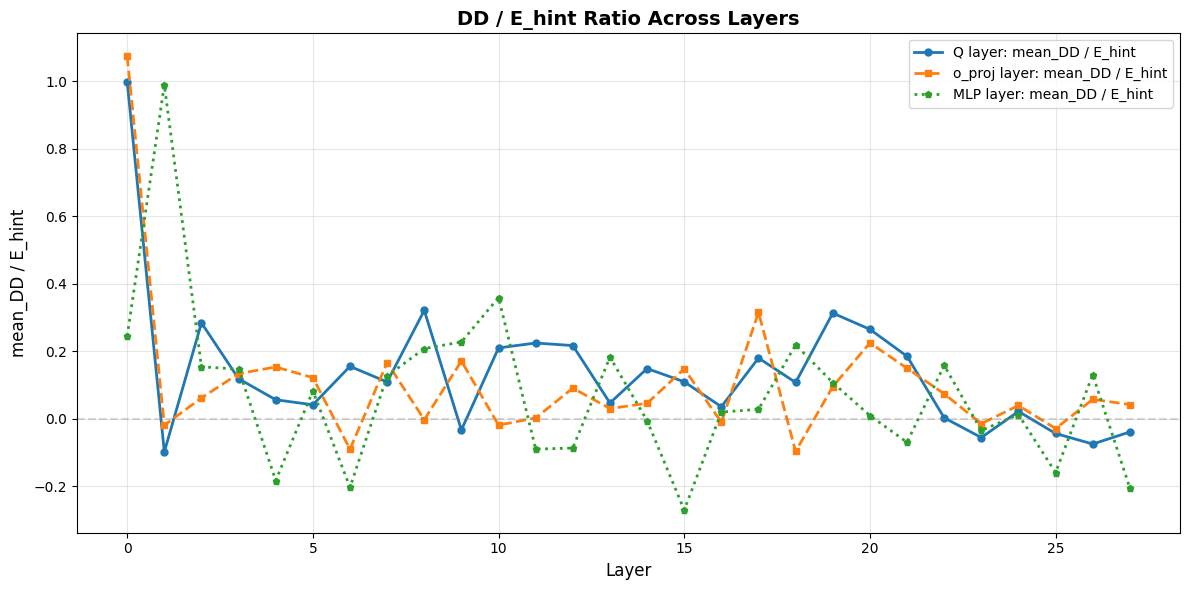

In [50]:
# Plot: mean_DD / E_hint for each layer and method
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics per layer
layers = sorted(all_results.keys())

# Compute mean_DD / mean_E_hint for each method
q_ratio = []
o_proj_ratio = []
mlp_ratio = []

for l in layers:
    # Q layer: mean(DD) / mean(E_hint)
    q_dd = np.mean([r["DD"] for r in all_results[l]["q"]])
    q_e_hint = np.mean([r["E_hint"] for r in all_results[l]["q"]])
    q_ratio.append(q_dd / q_e_hint if q_e_hint != 0 else 0)
    
    # o_proj layer
    o_proj_dd = np.mean([r["DD"] for r in all_results[l]["o_proj"]])
    o_proj_e_hint = np.mean([r["E_hint"] for r in all_results[l]["o_proj"]])
    o_proj_ratio.append(o_proj_dd / o_proj_e_hint if o_proj_e_hint != 0 else 0)
    
    # MLP layer
    mlp_dd = np.mean([r["DD"] for r in all_results[l]["mlp"]])
    mlp_e_hint = np.mean([r["E_hint"] for r in all_results[l]["mlp"]])
    mlp_ratio.append(mlp_dd / mlp_e_hint if mlp_e_hint != 0 else 0)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(layers, q_ratio, marker="o", label="Q layer: mean_DD / E_hint", linewidth=2, markersize=5, color="C0")
ax.plot(layers, o_proj_ratio, marker="s", label="o_proj layer: mean_DD / E_hint", linewidth=2, markersize=5, color="C1", linestyle="--")
ax.plot(layers, mlp_ratio, marker="p", label="MLP layer: mean_DD / E_hint", linewidth=2, markersize=5, color="C2", linestyle=":")

ax.axhline(y=0, color="gray", linestyle="--", alpha=0.3)
ax.set_xlabel("Layer", fontsize=12)
ax.set_ylabel("mean_DD / E_hint", fontsize=12)
ax.set_title("DD / E_hint Ratio Across Layers", fontsize=14, fontweight="bold")
ax.legend(loc="best", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("dd_over_ehint_by_layer.png", dpi=150, bbox_inches="tight")
plt.show()


## Head-Level Ablation Analysis

For the top 3 layers (by DD/E_hint) for each method, analyze individual heads.


In [51]:
# Identify top 3 layers (excluding layer 0) for each method
import numpy as np

# Compute DD/E_hint for each layer (excluding 0)
q_layer_ratios = {}
o_proj_layer_ratios = {}

for l in sorted(all_results.keys()):
    if l == 0:
        continue
    
    q_dd = np.mean([r["DD"] for r in all_results[l]["q"]])
    q_e_hint = np.mean([r["E_hint"] for r in all_results[l]["q"]])
    q_layer_ratios[l] = q_dd / q_e_hint if q_e_hint != 0 else 0
    
    o_proj_dd = np.mean([r["DD"] for r in all_results[l]["o_proj"]])
    o_proj_e_hint = np.mean([r["E_hint"] for r in all_results[l]["o_proj"]])
    o_proj_layer_ratios[l] = o_proj_dd / o_proj_e_hint if o_proj_e_hint != 0 else 0

# Get top 3 layers for each method
top_q_layers = sorted(q_layer_ratios.items(), key=lambda x: x[1], reverse=True)[:3]
top_o_proj_layers = sorted(o_proj_layer_ratios.items(), key=lambda x: x[1], reverse=True)[:3]

top_q_layer_indices = [l for l, _ in top_q_layers]
top_o_proj_layer_indices = [l for l, _ in top_o_proj_layers]

print(f"Top 3 Q layers: {top_q_layer_indices}")
print(f"Top 3 o_proj layers: {top_o_proj_layer_indices}")

Top 3 Q layers: [8, 19, 2]
Top 3 o_proj layers: [17, 20, 9]


In [52]:
# Small-scale test: validate head ablation logic
# Test with 1 layer, 1 head, first 2 problems only
test_layer = top_q_layer_indices[0] if top_q_layer_indices else 1
test_head = 0
test_problems = target_problems[:2]

# Temporarily override target_problems for testing
original_target_problems = target_problems
target_problems = test_problems

# Test Q ablation
test_results = compute_deltas(test_layer, "q", readout_pos=None, head_idx=test_head)
test_results = compute_effects(test_results)

# Restore
target_problems = original_target_problems

print(f"Test passed: computed {len(test_results)} results for L{test_layer}H{test_head}")
if test_results:
    print(f"  DD: {np.mean([r['DD'] for r in test_results]):.4f}")
    print(f"  E_hint: {np.mean([r['E_hint'] for r in test_results]):.4f}")

Computing Δ (q): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

Test passed: computed 2 results for L8H0
  DD: 0.3088
  E_hint: 6.8142


In [ ]:
# Compute head-level ablation for top layers
head_results_q = {}
head_results_o_proj = {}

# Q method: iterate through top 3 layers and all heads
for layer_idx in top_q_layer_indices:
    head_results_q[layer_idx] = {}
    for head_idx in range(NUM_HEADS):
        print(f"Q: Layer {layer_idx}, Head {head_idx}")
        results = compute_deltas(layer_idx, "q", readout_pos=None, head_idx=head_idx)
        results = compute_effects(results)
        head_results_q[layer_idx][head_idx] = results

# o_proj method: iterate through top 3 layers and all heads
for layer_idx in top_o_proj_layer_indices:
    head_results_o_proj[layer_idx] = {}
    for head_idx in range(NUM_HEADS):
        print(f"o_proj: Layer {layer_idx}, Head {head_idx}")
        results = compute_deltas(layer_idx, "o_proj", readout_pos=None, head_idx=head_idx)
        results = compute_effects(results)
        head_results_o_proj[layer_idx][head_idx] = results

Q: Layer 8, Head 0


Computing Δ (q): 100%|██████████| 70/70 [00:10<00:00,  6.95it/s]


Q: Layer 8, Head 1


Computing Δ (q): 100%|██████████| 70/70 [00:10<00:00,  6.85it/s]


Q: Layer 8, Head 2


Computing Δ (q):  73%|███████▎  | 51/70 [00:07<00:03,  6.25it/s]

In [ ]:
# Save head-level results
import os

os.makedirs("head_ablation_results/q", exist_ok=True)
os.makedirs("head_ablation_results/o_proj", exist_ok=True)

# Save Q results
for layer_idx in head_results_q:
    for head_idx in head_results_q[layer_idx]:
        filename = f"head_ablation_results/q/layer_{layer_idx}_head_{head_idx}.json"
        with open(filename, "w") as f:
            json.dump(head_results_q[layer_idx][head_idx], f, indent=2)

# Save o_proj results
for layer_idx in head_results_o_proj:
    for head_idx in head_results_o_proj[layer_idx]:
        filename = f"head_ablation_results/o_proj/layer_{layer_idx}_head_{head_idx}.json"
        with open(filename, "w") as f:
            json.dump(head_results_o_proj[layer_idx][head_idx], f, indent=2)

print("Head-level results saved")

In [ ]:
# Plot DD/E_hint for all heads, sorted by value
import matplotlib.pyplot as plt

# Collect all Q head results with labels
q_data = []
for layer_idx in head_results_q:
    for head_idx in head_results_q[layer_idx]:
        dd = np.mean([r["DD"] for r in head_results_q[layer_idx][head_idx]])
        e_hint = np.mean([r["E_hint"] for r in head_results_q[layer_idx][head_idx]])
        ratio = dd / e_hint if e_hint != 0 else 0
        q_data.append((f"L{layer_idx}H{head_idx}", ratio))

# Collect all o_proj head results with labels
o_proj_data = []
for layer_idx in head_results_o_proj:
    for head_idx in head_results_o_proj[layer_idx]:
        dd = np.mean([r["DD"] for r in head_results_o_proj[layer_idx][head_idx]])
        e_hint = np.mean([r["E_hint"] for r in head_results_o_proj[layer_idx][head_idx]])
        ratio = dd / e_hint if e_hint != 0 else 0
        o_proj_data.append((f"L{layer_idx}H{head_idx}", ratio))

# Sort by ratio (descending)
q_data.sort(key=lambda x: x[1], reverse=True)
o_proj_data.sort(key=lambda x: x[1], reverse=True)

# Plot Q results
q_labels, q_ratios = zip(*q_data) if q_data else ([], [])
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(range(len(q_labels)), q_ratios, color="C0")
ax.set_xticks(range(len(q_labels)))
ax.set_xticklabels(q_labels, rotation=45, ha="right")
ax.set_ylabel("mean_DD / E_hint", fontsize=12)
ax.set_title("Q Ablation: DD/E_hint by Head (sorted)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig("head_ablation_results/q_dd_over_ehint.png", dpi=150, bbox_inches="tight")
plt.show()

# Plot o_proj results
o_proj_labels, o_proj_ratios = zip(*o_proj_data) if o_proj_data else ([], [])
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(range(len(o_proj_labels)), o_proj_ratios, color="C1")
ax.set_xticks(range(len(o_proj_labels)))
ax.set_xticklabels(o_proj_labels, rotation=45, ha="right")
ax.set_ylabel("mean_DD / E_hint", fontsize=12)
ax.set_title("o_proj Ablation: DD/E_hint by Head (sorted)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig("head_ablation_results/o_proj_dd_over_ehint.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# Save results
with open("ablation_analysis_q.jsonl", "w") as f:
    for r in q_results:
        f.write(json.dumps(r) + "\n")

with open("ablation_analysis_o_proj.jsonl", "w") as f:
    for r in o_proj_results:
        f.write(json.dumps(r) + "\n")

print("Results saved")